#### Get y_list 

In [78]:
# Autoreload 
%load_ext autoreload
%autoreload 2

"""Set random seed"""
import torch 
torch.manual_seed(0) 
import numpy as np
np.random.seed(0)

from pathlib import Path
from phosphosite.dataset import psp_filtered
psp_filtered

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,uniprot_id,mod_rsd,mod,site,res,pos
0,P31946,T2-p,p,T2,T,2
1,P31946,S6-p,p,S6,S,6
2,P31946,Y21-p,p,Y21,Y,21
3,P31946,T32-p,p,T32,T,32
4,P31946,S39-p,p,S39,S,39
...,...,...,...,...,...,...
239815,Q8IYH5,S474-p,p,S474,S,474
239816,Q8IYH5,S606-p,p,S606,S,606
239817,Q8IYH5,Y670-p,p,Y670,Y,670
239818,Q8IYH5,S677-p,p,S677,S,677


In [79]:
# TODO: 
# have a process that filters down this list to only phosphosites that MAP ON 
# to the uniprot_id (i.e. same localised Serine as in the sequence) 
# use the same uniprot_id sequences as the embeddings and whatever the alphafold structures
# will have. 

In [80]:
from phosphosite.dataset.psp import load_psp_alternate
psp = load_psp_alternate(
    include_columns=["uniprot_id", "res", "pos", ]
)
psp

,uniprot_id,res,pos
0,P31946,T,2
1,P31946,S,6
2,P31946,Y,21
3,P31946,T,32
4,P31946,S,39
...,...,...,...
239815,Q8IYH5,S,474
239816,Q8IYH5,S,606
239817,Q8IYH5,Y,670
239818,Q8IYH5,S,677


In [81]:
psp.res.value_counts()

S    141756
T     58714
Y     39350
Name: res, dtype: int64

In [82]:
# Order by uniprot_id 
psp = psp.sort_values(by=["uniprot_id", "res", "pos"])
psp

,uniprot_id,res,pos
26255,A0A024R4G9,S,16
26256,A0A024R4G9,S,20
26254,A0A024R4G9,T,14
156759,A0A075B759,S,40
156761,A0A075B759,T,93
...,...,...,...
111988,Q9Y6Y9,Y,131
43374,Q9Y6Z7,S,141
43375,Q9Y6Z7,T,155
64576,Q9YNA8,S,465


### TODO: filter all sites here by whether their (pos, res) maps to the correct residue using the available uniprot sequence.

This will exclude all sites that do not map correctly.

In [83]:
# subtract 1 from pos to get index. 
psp["index"] = psp["pos"] - 1

In [84]:
# group by uniprot_id to get the list of phosphosites for each uniprot_id (positions)
psp = psp.groupby("uniprot_id").agg(list)
psp

,res,pos,index
uniprot_id,,,
A0A024R4G9,"[S, S, T]","[16, 20, 14]","[15, 19, 13]"
A0A075B759,"[S, T, T, Y]","[40, 93, 119, 79]","[39, 92, 118, 78]"
A0A087WUL8,"[S, S, S, S, S, S, S, S, S, S, S, S, S, S]","[364, 608, 852, 1096, 1340, 1584, 1828, 2072, ...","[363, 607, 851, 1095, 1339, 1583, 1827, 2071, ..."
A0A096LNH2,"[S, S, S]","[799, 801, 895]","[798, 800, 894]"
A0A096LP49,"[S, S, S]","[478, 519, 566]","[477, 518, 565]"
...,...,...,...
Q9Y6Y8,"[S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, ...","[134, 136, 258, 602, 636, 712, 737, 740, 742, ...","[133, 135, 257, 601, 635, 711, 736, 739, 741, ..."
Q9Y6Y9,"[Y, Y]","[22, 131]","[21, 130]"
Q9Y6Z7,"[S, T]","[141, 155]","[140, 154]"


#### Save unique protein ids for structure download.

In [85]:
psp_uniprot_ids_to_use = psp.index.tolist()

with open("psp_uniprot_ids_to_use.txt", "w") as f:
    f.write("\n".join(psp_uniprot_ids_to_use))

In [86]:
# turn dataframe into a dictionary
site_dict = psp.to_dict(orient="index", )
site_dict

{'A0A024R4G9': {'res': ['S', 'S', 'T'],
  'pos': [16, 20, 14],
  'index': [15, 19, 13]},
 'A0A075B759': {'res': ['S', 'T', 'T', 'Y'],
  'pos': [40, 93, 119, 79],
  'index': [39, 92, 118, 78]},
 'A0A087WUL8': {'res': ['S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S',
   'S'],
  'pos': [364,
   608,
   852,
   1096,
   1340,
   1584,
   1828,
   2072,
   2316,
   2560,
   2804,
   3048,
   3292,
   3536],
  'index': [363,
   607,
   851,
   1095,
   1339,
   1583,
   1827,
   2071,
   2315,
   2559,
   2803,
   3047,
   3291,
   3535]},
 'A0A096LNH2': {'res': ['S', 'S', 'S'],
  'pos': [799, 801, 895],
  'index': [798, 800, 894]},
 'A0A096LP49': {'res': ['S', 'S', 'S'],
  'pos': [478, 519, 566],
  'index': [477, 518, 565]},
 'A0A096LP55': {'res': ['T'], 'pos': [11], 'index': [10]},
 'A0A0A0MR41': {'res': ['T'], 'pos': [616], 'index': [615]},
 'A0A0B4J2A2': {'res': ['S', 'S', 'S', 'S', 'T', 'Y'],
  'pos': [40, 95, 99, 110, 119, 79],
  'ind

In [87]:
pos_position_dict = dict(zip(psp.index, psp["index"]))
pos_position_dict 

{'A0A024R4G9': [15, 19, 13],
 'A0A075B759': [39, 92, 118, 78],
 'A0A087WUL8': [363,
  607,
  851,
  1095,
  1339,
  1583,
  1827,
  2071,
  2315,
  2559,
  2803,
  3047,
  3291,
  3535],
 'A0A096LNH2': [798, 800, 894],
 'A0A096LP49': [477, 518, 565],
 'A0A096LP55': [10],
 'A0A0A0MR41': [615],
 'A0A0B4J2A2': [39, 94, 98, 109, 118, 78],
 'A0A0B4J2F2': [574],
 'A0A0C4DFX5': [8],
 'A0A0J9YWL9': [30,
  373,
  375,
  377,
  436,
  438,
  440,
  457,
  459,
  461,
  604,
  606,
  608,
  625,
  629,
  686,
  690,
  707,
  709,
  711,
  728,
  732,
  852,
  854,
  856,
  35,
  680,
  722,
  34],
 'A0A0U1RQK7': [134, 122, 140],
 'A0A0U1RR07': [1023,
  1040,
  1071,
  1207,
  1211,
  1287,
  1319,
  1370,
  1408,
  1523,
  1561,
  1585,
  1615,
  1739,
  1099,
  1663,
  889,
  890,
  1515],
 'A0A1B0GTR3': [59, 60],
 'A0A5F9ZHR4': [330, 334],
 'A0AUZ9': [104, 204, 463, 525, 713, 821, 796, 791],
 'A0AV02': [98, 487, 661, 664, 468, 484, 106],
 'A0AV96': [44,
  395,
  507,
  539,
  41,
  518,
  532,


### Load in negative position dict.

In [88]:
filepath = Path("../negative_examples/neg_position_dict.json")
# read in the json file
import json
with open(filepath, "r") as f:
    neg_position_dict = json.load(f)

In [89]:
# Negative examples
import torch
indexes_dict = {} 
for key, pos_idx in pos_position_dict.items():


    
    pos_idx = torch.tensor(pos_idx)
    pos_y = torch.ones(pos_idx.shape[0])
    
    if key in neg_position_dict:
        neg_idx = neg_position_dict[key]
    else:
        neg_idx = []

    neg_idx = torch.tensor(neg_idx)
    neg_y = torch.zeros(neg_idx.shape[0])

    indexes_dict[key] = dict(
        idx=torch.cat([pos_idx, neg_idx]),
        y=torch.cat([pos_y, neg_y])
    )
    

In [90]:
len(indexes_dict)

17585

In [91]:
indexes_dict

{'A0A024R4G9': {'idx': tensor([15., 19., 13.]), 'y': tensor([1., 1., 1.])},
 'A0A075B759': {'idx': tensor([ 39,  92, 118,  78,  31, 146,  72,  94, 156, 152]),
  'y': tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])},
 'A0A087WUL8': {'idx': tensor([ 363,  607,  851, 1095, 1339, 1583, 1827, 2071, 2315, 2559, 2803, 3047,
          3291, 3535,   22,   94,  874,  312,  519,  297, 1121,  447,  714,  308,
           537, 1202,  498,  444,  305,  549,  210,  343,  184,  691,  688,  418,
          1384,  652,  896,  813,    3,   57,  633]),
  'y': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.])},
 'A0A096LNH2': {'idx': tensor([798., 800., 894.]), 'y': tensor([1., 1., 1.])},
 'A0A096LP49': {'idx': tensor([ 477,  518,  565,  811,  813,  167,  828,  839,  452,  491,  718,  754,
          1053,  703,  740,  715,  357,  713,  699,  180,  360, 1008, 

In [92]:
# Number of proteins in indexes_dict that contain only positive examples 

i = 0
for key, value in indexes_dict.items():
    if value["y"].sum() == value["y"].shape[0]:
        i += 1
i

630

In [93]:
# Number of proteins in indexes_dict that contain only negative examples
i = 0
for key, value in indexes_dict.items():
    if value["y"].sum() == 0:
        i += 1
i

0

### rerun with union of all keys to make sure we don't miss any

In [94]:
all_proteins = pos_position_dict.keys() | neg_position_dict.keys()
len(pos_position_dict), len(neg_position_dict), len(all_proteins)

(17585, 16955, 17585)

In [95]:
# Create indexes_dict
# Negative examples
indexes_dict = {} 
for key in all_proteins:
    pos_idx = pos_position_dict[key] if key in pos_position_dict else []
    neg_idx = neg_position_dict[key] if key in neg_position_dict else []
 
    pos_idx = torch.tensor(pos_idx)
    pos_y = torch.ones(pos_idx.shape[0])
    
    neg_idx = torch.tensor(neg_idx)
    neg_y = torch.zeros(neg_idx.shape[0])

    indexes_dict[key] = dict(
        idx=torch.cat([pos_idx, neg_idx]),
        y=torch.cat([pos_y, neg_y])
    )
    

`idx` is a tensor of indexes for the nodes that should be evaluated by the model.  
`y` is a tensor corresponding to `idx` of the true values that should be output for each of the nodes.

In [96]:
len(indexes_dict)

17585

In [97]:
indexes_dict

{'Q92547': {'idx': tensor([ 141,  152,  300,  349,  369,  491,  497,  498,  553,  586,  740,  746,
           804,  816,  835,  852,  859,  863,  877,  878,  885,  887,  997, 1001,
          1011, 1015, 1092, 1125, 1137, 1158, 1182, 1191, 1215, 1503,  184,  187,
           297,  299,  617,  741,  775,  778,  821,  847,  860, 1061, 1063, 1104,
          1220, 1230,  186,  493, 1490,  957,  726,  664,  178, 1056,  454,  309,
           414,  623,  135,  262, 1386,  940,  106,   55, 1272, 1461,  364,   57,
           114,   37,  916,  986, 1348]),
  'y': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.])},
 'Q5JSP0': {'idx': tensor([ 55,  67, 100, 127, 135, 396, 413, 445, 485, 525, 546, 6

#### Save index dict

In [98]:
# TODO: 
# - have a more elegant dataframe that we can use to store all the positive / negative examples, and allow easy plotting
# for any given version of this dataframe to see the distribution of the data. 
# this should then be given to a function that turns it into an `index_dict` of tensors for use with the `ProteinGraphDataset`.


In [99]:
# Save indexes_dict
from phosphosite.utils.io import save_index_dict, load_index_dict

filepath = Path("./indexes_dict_original.json")
save_index_dict(
    index_dict=indexes_dict,
    filepath=filepath,
    overwrite=True,
)

# Load indexes_dict
indexes_dict = load_index_dict(filepath=filepath)

#### Filter index_dict to make sure there are no index out of bounds errors.

In [100]:
from phosphosite.dataset import sequence_dict

unavailable = []
problematic_uniprot_ids = []
clean_indexes_dict = {}
for uid, value in indexes_dict.items():
    if uid in sequence_dict:
        seq = sequence_dict[uid]
    else: 
        unavailable.append(uid)
        clean_indexes_dict[uid] = value
        continue


    idx, y = value["idx"], value["y"]
    y   =   y[idx < len(seq)]
    idx = idx[idx < len(seq)]

    
    clean_indexes_dict[uid] = dict(
        idx=idx,
        y=y,
    )
    
    # Check if we've removed any 
    if idx.shape[0] != value["idx"].shape[0]:
        print(f"Removed {value['idx'].shape[0] - idx.shape[0]} indexes from {uid}")
        problematic_uniprot_ids.append(uid)


Removed 1 indexes from O95954
Removed 4 indexes from Q92843
Removed 1 indexes from Q03518
Removed 2 indexes from O76039
Removed 5 indexes from Q86Y39
Removed 7 indexes from Q9ULJ8
Removed 2 indexes from Q9H9P5
Removed 1 indexes from P15692
Removed 11 indexes from Q8IY67
Removed 3 indexes from Q96A59
Removed 1 indexes from Q86SQ6
Removed 2 indexes from Q01196
Removed 2 indexes from P23760
Removed 1 indexes from Q9HBY8
Removed 4 indexes from Q13439
Removed 1 indexes from Q86SI9
Removed 7 indexes from A6NNF4
Removed 2 indexes from Q9ULR0
Removed 3 indexes from Q12983
Removed 3 indexes from Q86XN8
Removed 3 indexes from B8ZZ34
Removed 2 indexes from Q9Y2D5
Removed 3 indexes from O75486
Removed 3 indexes from Q9H579
Removed 1 indexes from Q92896
Removed 8 indexes from Q96ME1
Removed 3 indexes from Q8IWZ3
Removed 2 indexes from Q9Y6N9
Removed 3 indexes from Q8N9C0
Removed 1 indexes from Q96HB5
Removed 1 indexes from Q9Y2X7
Removed 1 indexes from Q8TBZ3
Removed 1 indexes from Q0GE19
Removed 3

In [101]:
for uid, val in clean_indexes_dict.items():
    assert val["idx"].shape[0] == val["y"].shape[0]

In [102]:
len(clean_indexes_dict), len(indexes_dict), len(problematic_uniprot_ids)

(17585, 17585, 128)

In [103]:
different_uids = []
for uid, val in clean_indexes_dict.items():
    # check if different to original
    if uid in indexes_dict:
        if not torch.equal(val["idx"], indexes_dict[uid]["idx"]):
            different_uids.append(uid)

In [104]:
len(different_uids) # as expected, this is the "problematic" list.

128

In [105]:
# Save
filepath = Path("./indexes_dict.json")
save_index_dict(
    index_dict=clean_indexes_dict,
    filepath=filepath,
    overwrite=True,
)
clean_indexes_dict = load_index_dict(filepath=filepath)
clean_indexes_dict

{'Q92547': {'idx': tensor([ 141,  152,  300,  349,  369,  491,  497,  498,  553,  586,  740,  746,
           804,  816,  835,  852,  859,  863,  877,  878,  885,  887,  997, 1001,
          1011, 1015, 1092, 1125, 1137, 1158, 1182, 1191, 1215, 1503,  184,  187,
           297,  299,  617,  741,  775,  778,  821,  847,  860, 1061, 1063, 1104,
          1220, 1230,  186,  493, 1490,  957,  726,  664,  178, 1056,  454,  309,
           414,  623,  135,  262, 1386,  940,  106,   55, 1272, 1461,  364,   57,
           114,   37,  916,  986, 1348]),
  'y': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.])},
 'Q5JSP0': {'idx': tensor([ 55,  67, 100, 127, 135, 396, 413, 445, 485, 525, 546, 6

In [106]:
# Double check 
naked_proteins = []
for uid, val in clean_indexes_dict.items():
    if len(val["idx"]) == 0:
        print(uid)
        naked_proteins.append(uid)
        continue
    if uid in sequence_dict:
        seq = sequence_dict[uid]
        assert max(val["idx"]) < len(seq)

Q86Y39
Q86SI9
Q9H579
Q9BTM9


In [107]:
# Save naked proteins 
filepath = Path("./naked_proteins.txt")
with open(filepath, "w") as f:
    f.write("\n".join(naked_proteins))

# ! NOTE !

In [108]:
# NOTE: 
# Whilst this is a fix to the out of bounds issue, we still need to make sure that 
# the actual mappings of positions to residues is correct 
# i.e. if there is an out of bounds phosphosite position in PSP, we can't just 
# expect to still use all the 'in bounds' sites on that same protein ID from PSP 
# without checking that the positions map to STY sites on the AlphaFold / T5 version 
# of the sequence. 

#### Plot per-protein balance of positive and negative examples. 

In [109]:
# plot histogram of the ratio of positive to negative examples per protein
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
ratios = []
for key, value in indexes_dict.items():
    # num pos : total
    num_pos = value["y"].sum()
    ratio = float(num_pos / value["y"].shape[0])

    # if is inf 
   
        
    ratios.append(ratio)



AttributeError: 'list' object has no attribute 'sum'

In [ ]:
indexes_dict["P62277"]

{'idx': tensor([ 11.,  13.,  20.,  29.,  47.,  56., 119.,  23.,  28.,  45.,  17.,  37.,
          88.]),
 'y': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [ ]:
# max of ratio 
min(ratios)

0.016129031777381897

<Axes: ylabel='Density'>

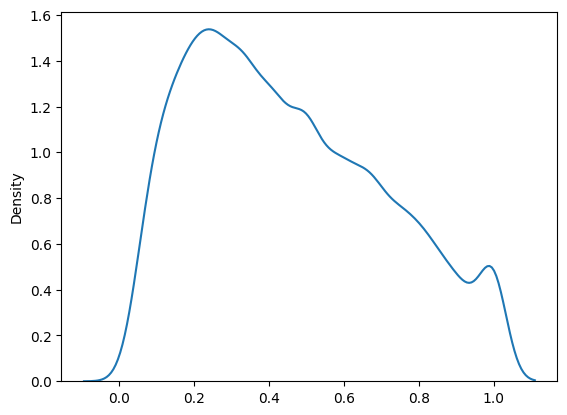

In [ ]:
sns.kdeplot(ratios) 

In [ ]:
# Get

<Axes: ylabel='Count'>

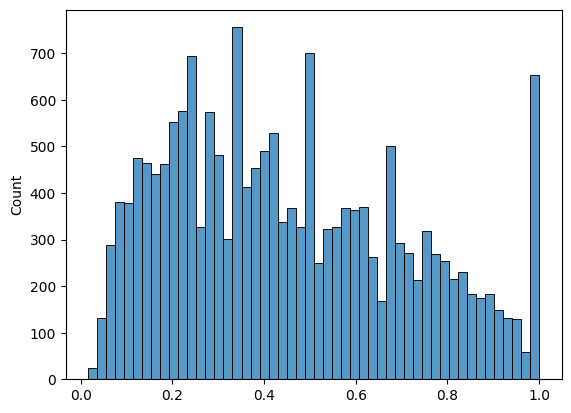

In [ ]:
sns.histplot(ratios, bins=50)

<Axes: ylabel='Count'>

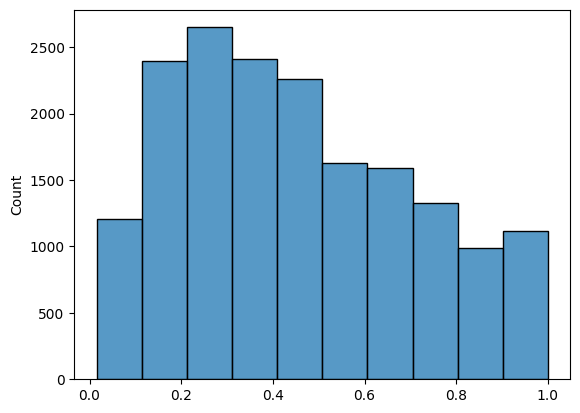

In [ ]:
sns.histplot(ratios, bins=10)

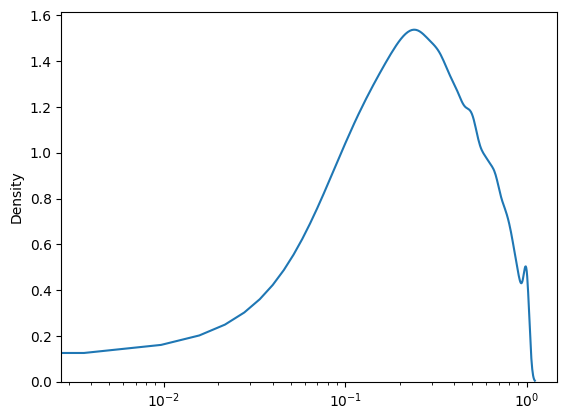

In [ ]:
sns.kdeplot(ratios) 

# change scale to log
plt.xscale("log")

In [ ]:
# Get value counts of ratios
import pandas as pd
df = pd.DataFrame(ratios, columns=["ratio"])
df["ratio"].value_counts()

0.500000    672
1.000000    630
0.333333    590
0.250000    454
0.200000    377
           ... 
0.177778      1
0.888000      1
0.611842      1
0.346939      1
0.684932      1
Name: ratio, Length: 1707, dtype: int64

### Testing tensor indexing

In [ ]:
import torch 
x = torch.tensor([0, 1, 2, 3, 4, 5])
indexes = torch.tensor([0, 1, 2, 4])
x

tensor([0, 1, 2, 3, 4, 5])

In [ ]:
x[indexes]

tensor([0, 1, 2, 4])

In [ ]:
out_of_order_indexes = torch.tensor([4, 2, 1, 0, 5, 5, 2])
x[out_of_order_indexes]

tensor([4, 2, 1, 0, 5, 5, 2])

#### Get all downloaded uniprot IDs to create dataset

In [ ]:
from phosphosite import PHOSPHOSITE_PREDICT_DIR
root_dir = PHOSPHOSITE_PREDICT_DIR / "protein_graph_dataset"


import glob 
extension = "pdb"  # "pt"
which_dir = "raw" # "processed"
query = str(root_dir / which_dir / "*.{extension}".format(extension=extension))
downloaded_fns = glob.glob(query)
uniprot_ids = [Path(a).stem for a in downloaded_fns]
len(uniprot_ids)

17223

#### Load dataset with `y_list` included

In [ ]:
from phosphosite.ml.dataset import PhosphoGraphDataset

#uniprot_ids = uniprot_ids[0:10]
ds = PhosphoGraphDataset(
    root=root_dir,
    uniprot_ids=uniprot_ids, 
    y_label_map=indexes_dict,
)

[10/23/23 10:41:17] WARNING  To use the Graphein submodule                                         ]8;id=979523;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=99294;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

                    WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=637755;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=196227;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=209855;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=926400;file:///home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [ ]:
ds.data

/home/cim/anaconda3/envs/phosphosite_ml/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[7095, 1024], edge_index=[2, 2549], node_id=[10], b_factor=[7095], name=[10], num_nodes=7095)

In [ ]:
len(ds.uniprot_ids)

17223

### Alternate dataset modified from `compot` 

This dataset is an alternate to the above `InMemoryDataset`-inheriting class.  


This `PhosphositeGraphDataset` class loads from disk and adds the `y` and `y_index` attributes to the data object which corresponds to the binary labels (phosphosite or unsite), and the indexes of nodes that have these labels; respectively. 

#### Setup

Load config objects etc.

In [ ]:
from graphein.ml import ProteinGraphDataset
from pathlib import Path
import torch

from tqdm import tqdm

In [ ]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.edges.distance import add_distance_threshold

from functools import partial

long_interaction_threshold = 5 # seq positions 
edge_threshold_distance = 6.0 # Å
new_edge_funcs = {"edge_construction_functions": [
    partial(
    add_distance_threshold, long_interaction_threshold=long_interaction_threshold, threshold=edge_threshold_distance)
]}
config = ProteinGraphConfig(
    granularity="CA",
    **new_edge_funcs,
)

from graphein.ml.conversion import GraphFormatConvertor

columns = [
    "b_factor",
    "name",
    "edge_index",
    "x", # T5 per-residue embedding
]
convertor = GraphFormatConvertor(
    src_format="nx", dst_format="pyg", verbose="gnn",
    columns=columns,
)

# List of functions that consume a nx.Graph and return a nx.Graph. Applied to graphs after construction but before conversion to pyg
from phosphosite.graphs.pyg import add_per_residue_embedding
graph_transforms = [
    add_per_residue_embedding,
]

# TODO: copy across code that adds the residue embedding from `compot`. 

In [ ]:
from phosphosite import PHOSPHOSITE_PREDICT_DIR
root_dir =  PHOSPHOSITE_PREDICT_DIR / "protein_graph_dataset"

In [ ]:
all_ids = list(psp.index)
processed_filenames = [Path(a).stem for a in glob.glob(str(root_dir / "processed" / "*.pt"))]
downloaded_filenames = [Path(a).stem for a in glob.glob(str(root_dir / "raw" / "*.pdb"))]


uniprot_ids = [a for a in all_ids if a in processed_filenames]
len(all_ids), len(downloaded_filenames), len(processed_filenames), len(uniprot_ids)

(17585, 17223, 17067, 17063)

In [ ]:
uniprot_ids_downloaded = [a for a in all_ids if a in downloaded_filenames]
len(uniprot_ids_downloaded)

17222

In [ ]:
for u in uniprot_ids_downloaded: 
    d = indexes_dict[u]
    continue

In [ ]:
root_dir 

PosixPath('/home/cim/STRUCTURAL_MOTIFS/phosphosite/notebooks/phosphosite_prediction/protein_graph_dataset')

In [ ]:
with open(root_dir / "valid_uniprot_ids.txt", "r") as f:
    valid_uniprot_ids = f.read().splitlines()

not_valid = [a for a in uniprot_ids_downloaded if a not in valid_uniprot_ids]
len(not_valid), len(uniprot_ids_downloaded)

(17173, 17222)

In [ ]:
len(processed_filenames)

17067

In [ ]:
not_yet_processed = [a for a in uniprot_ids_downloaded if a not in processed_filenames]
len(not_yet_processed)

159

In [ ]:
from phosphosite.ml.graph_dataset import PhosphositeGraphDataset 
kwargs = dict(
    root=root_dir,
    graphein_config=config, 
    graph_transformation_funcs=graph_transforms,
    graph_format_convertor=convertor,
    pre_transform=None, # before saved to disk , after PyG conversion 
    pre_filter=None,    # whether it will be in final dataset
)

# Attempt to load the graphs that failed.
start = 50
n = 100
ds = PhosphositeGraphDataset(
    uniprot_ids=not_yet_processed[0:5],
    #uniprot_ids=not_valid[start:start+n],
    y_label_map=indexes_dict,
    **kwargs,
)
ds

Processing...
  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

failed to convert graph None
failed to convert graph None
failed to convert graph None
failed to convert graph None
failed to convert graph None



Done!


PhosphositeGraphDataset()

### Dataset Actual

In [ ]:
# Load in the actual dataset (i.e. processed filenames)
ds = PhosphositeGraphDataset(
    uniprot_ids=processed_filenames,
    y_label_map=indexes_dict,
    **kwargs,
)

In [ ]:
ds[0].y_index

tensor([ 345,  429,  430,  719,  789,  884,  899,  900,  917,  930, 1219,  340,
         344,  396,  400,  516,  974, 1123, 1126, 1135,  354, 1193, 1124, 1290,
        1295, 1250, 1129, 1163,  198, 1051,  659,  651,  621,  184,  542,  351,
         415,  145,  508,  448,  383,  372,  154,  992,   60,   59,  287,  523,
        1067,  538,  968,  366,  369, 1054])

In [ ]:
ds[0].y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Number of failed graphs

In [ ]:
processed_filenames = [Path(a).stem for a in glob.glob(str(root_dir / "processed" / "*.pt"))]
not_yet_processed = [a for a in uniprot_ids_downloaded if a not in processed_filenames]
len(not_yet_processed)

159

In [ ]:
len(processed_filenames), ds

(17067, PhosphositeGraphDataset(17067))

### Construct dataloaders

In [ ]:
from phosphosite.ml import get_dataloader_split
train_loader, valid_loader, test_loader = get_dataloader_split(ds, batch_size=8, train_batch_size=8)
len(train_loader), len(valid_loader), len(test_loader)

(1365, 342, 427)

In [ ]:
batch = next(iter(train_loader))
batch

DataBatch(x=[2303, 1024], edge_index=[2, 756], node_id=[8], b_factor=[2303], name=[8], num_nodes=2303, y_index=[86], y=[86], batch=[2303], ptr=[9])

In [ ]:
batch.y_index

tensor([ 343.,  416.,  421.,  431.,  397.,  336.,  231.,   96.,  409.,  412.,
         388.,  387.,  379.,  274.,  102.,  373.,  278.,  239.,  515.,  571.,
         617.,  655.,  763.,  681.,  574.,  669.,  755.,  774.,  636.,  614.,
         629.,  632.,  840., 1191., 1303., 1335.,  837., 1314., 1328., 1349.,
         839.,  850.,  929.,  996., 1078., 1317., 1336., 1120., 1139., 1267.,
        1154.,  814., 1052., 1156., 1385.,  908., 1084., 1419., 1495., 1531.,
        1584., 1507., 1435., 1754., 1752., 1773., 1862., 1875., 1902., 1885.,
        1886., 1952., 1937., 1932., 1943., 2159., 2244., 2013., 2210., 2051.,
        2184., 2147., 1995., 1998., 2011., 2045.])

In [ ]:
batch.name

['Q9NVA4',
 'P03973',
 'Q7Z6K5',
 'A0AV96',
 'P0DMR1',
 'P82663',
 'P61366',
 'Q8NH54']

In [ ]:
batch.y

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
"mask" in batch

False

In [ ]:
# index batch.y_index where batch.y == 1 
batch.y_index[batch.y == 0]

tensor([ 336.,  231.,   96.,  409.,  412.,  388.,  387.,  379.,  274.,  102.,
         373.,  278.,  239.,  755.,  774.,  636.,  614.,  629.,  632., 1120.,
        1139., 1267., 1154.,  814., 1052., 1156., 1385.,  908., 1084., 1507.,
        1435., 1773., 1875., 1902., 1885., 1886., 1952., 1937., 1932., 1943.,
        2244., 2013., 2210., 2051., 2184., 2147., 1995., 1998., 2011., 2045.])

### Test batch on model forward pass

In [ ]:
from phosphosite.model import PhosphoGAT

model = PhosphoGAT()
model.eval()

batch = next(iter(train_loader))
y_hat = model(batch)
y = batch.y 

In [ ]:
y_hat, y

(tensor([[0.4858],
         [0.4825],
         [0.4694],
         ...,
         [0.4879],
         [0.4697],
         [0.4720]], grad_fn=<SigmoidBackward0>),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0.]))

In [ ]:
y.shape

torch.Size([185])

In [ ]:
# turn y_hat into int
y_hat = torch.argmax(y_hat, dim=1)
y_hat.shape

torch.Size([4279])

In [ ]:
y_hat.sum(), y.sum()

(tensor(0), tensor(102.))

### Test masked loss function with `y_index`

In [ ]:
batch

DataBatch(x=[4279, 1024], edge_index=[2, 2142], node_id=[8], b_factor=[4279], name=[8], num_nodes=4279, y_index=[185], y=[185], batch=[4279], ptr=[9])

In [ ]:
from phosphosite.ml import MaskedBinaryCrossEntropy, calculate_masked_accuracy
accuracy = calculate_masked_accuracy

y_sparse = batch.y 
y_index = batch.y_index
y_hat = model(batch)

# flatten to be 1 dimension 
y_sparse = y_sparse.flatten()
y_index = y_index.flatten()
y_hat = y_hat.flatten()

y_sparse.shape, y_index.shape, y_hat.shape





(torch.Size([185]), torch.Size([185]), torch.Size([4279]))

In [ ]:
loss_func = MaskedBinaryCrossEntropy()

# Use `y_index` to create mask 
mask = torch.zeros_like(y_hat)
y = torch.zeros_like(y_hat)
# set y to be y_sparse at the index of y_index
y[y_index] = y_sparse
mask[y_index] = 1
mask

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
mask.sum(), len(y_index) # should be different if there are duplicates in y_index.

(tensor(185.), 185)

In [ ]:
mask.shape, y_hat.shape # should be the same regardless of duplicates in y_index

(torch.Size([4279]), torch.Size([4279]))

#### Test loss function

In [ ]:
y_hat.shape, y.shape, mask.shape

(torch.Size([4279]), torch.Size([4279]), torch.Size([4279]))

In [ ]:
y.sum(), y_sparse.sum() 

(tensor(102.), tensor(102.))

In [ ]:
y.sum() / y_sparse.shape[0] # ratio of positive examples

tensor(0.5514)

In [ ]:
loss = loss_func(y_hat, y, mask=mask)


In [ ]:
loss

tensor(0.6995, grad_fn=<DivBackward0>)

In [ ]:
acc = accuracy(y_hat, y, mask=mask)
acc

tensor(0.4270)

### Find duplicate value

In [ ]:
# mask values where > 0 
len(mask[mask > 0]) 

185

In [ ]:
y_index.shape, y_index.unique().shape

(torch.Size([185]), torch.Size([185]))

In [ ]:
# find duplicates 
# find value counts of y_index
import pandas as pd
df = pd.DataFrame(y_index, columns=["y_index"])

# show value counts where > 1
counts = df["y_index"].value_counts()
counts[counts > 1]

Series([], Name: y_index, dtype: int64)

In [ ]:
mask[984]

tensor(0.)

In [ ]:
# Find the index of the value 984 in y_index
# NOTE: this is no longer the case as we have run this with a different seed.
#y_index.tolist().index(984)

In [ ]:

""" 
>>> n = 42
>>> y_index[n:n+2]
tensor([984, 984])
>>> y[n:n+2]
tensor([1., 1.])

"""
#

' \nn = 42\ny_index[n:n+2]\ntensor([984, 984])\ny[n:n+2]\ntensor([1., 1.])\n\n'

#### Test `predict_step` and turning into dataframe.

In [ ]:
# Get batch setup
y_sparse = batch.y 
y_index = batch.y_index
y_hat = model(batch)        # forward pass

y_sparse = y_sparse.flatten()
y_index = y_index.flatten()
y_hat = y_hat.flatten()
mask = torch.zeros_like(y_hat)
y = torch.zeros_like(y_hat)

y[y_index] = y_sparse   # set y to be y_sparse at the index of y_index
mask[y_index] = 1
mask

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
batch

DataBatch(x=[4279, 1024], edge_index=[2, 2142], node_id=[8], b_factor=[4279], name=[8], num_nodes=4279, y_index=[185], y=[185], batch=[4279], ptr=[9])

In [ ]:
np.round(y_hat.detach().numpy()).tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
position = (y_index + 1).tolist()
y_values = y.tolist()
y_hat_values = y_hat.tolist()

# Threshold to give prediction 
threshold = 0.5
# Round to integer 1 or 0 
prediction_values = np.round(y_hat_values)
prediction_values = prediction_values.tolist()







In [ ]:
prediction_values

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
# Get residue from `y_index`
# Need to use batch_idx to get the correct uniprot_id
batch_idx = 0
uniprot_id = uniprot_ids[batch_idx]
uniprot_id

'Q9H845'

In [ ]:
batch

DataBatch(x=[4279, 1024], edge_index=[2, 2142], node_id=[8], b_factor=[4279], name=[8], num_nodes=4279, y_index=[185], y=[185], batch=[4279], ptr=[9])

In [ ]:
node_id = batch.node_id
type(node_id[0])

list

In [ ]:
summed = 0
for n in node_id:
    summed += len(n)
summed

4279

In [ ]:
y_index.shape, batch.y.shape

(torch.Size([185]), torch.Size([185]))

In [ ]:
batch.ptr

tensor([   0,  621,  834, 1693, 2745, 3578, 3662, 3968, 4279])

In [ ]:
batch_idx = batch.batch 

# Select the batch_idx for each y value (indexing with `y_index`)
batch_idx = batch_idx[y_index]
batch_idx

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [ ]:
np.array(batch.name)[batch_idx]

array(['Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845',
       'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845',
       'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845',
       'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845', 'Q9H845',
       'Q9H845', 'Q9H845', 'Q9UQN3', 'Q9UQN3', 'Q9UQN3', 'Q9UQN3',
       'Q9UQN3', 'Q9UQN3', 'Q9UQN3', 'Q9UQN3', 'Q9UQN3', 'Q9UQN3',
       'Q9UQN3', 'Q9UQN3', 'Q9UQN3', 'Q96JP9', 'Q96JP9', 'Q96JP9',
       'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9',
       'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9',
       'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9',
       'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9', 'Q96JP9',
       'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1',
       'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1',
       'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1',
       'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AVT1', 'A0AV

In [ ]:
# Get the `node_id` for all the `y_index` nodes. 
# Flatten 2D node_id list of lists to a single-dimension numpy array
node_id_flat = np.array([item for sublist in node_id for item in sublist], dtype=str)
node_id_flat

array(['A:MET:1', 'A:SER:2', 'A:GLY:3', ..., 'A:GLU:309', 'A:VAL:310',
       'A:ILE:311'], dtype='<U10')

In [ ]:
y_index

tensor([ 186,  233,  236,  305,  308,  336,  473,  157,  228,  324,  610,  461,
         411,  540,  138,  125,  359,  569,  510,  575,  353,  552,   23,   32,
         180,  209,  699,  706,  723,  773,  807,  810,  814,  819,  629,  644,
         709,  817,  758, 1498, 1578, 1667, 1501, 1563, 1685, 1374, 1591, 1594,
        1593, 1646, 1650, 1637, 1619, 1036,  885,  919, 1632, 1092, 1344, 1343,
        1117, 1323, 1062, 1085, 1516, 1514, 1708, 1728, 1841, 1993, 2429, 2435,
        2643, 1746, 1838, 1933, 1938, 2329, 2743, 1736, 2671, 2686, 2268, 2051,
        2052, 2457, 1951, 1754, 2608, 2613, 1968, 2532, 2009, 2056, 2540, 2713,
        1830, 1877, 2188, 1829, 2790, 2793, 2798, 2861, 2870, 2871, 2897, 3405,
        3442, 3444, 3458, 3481, 3485, 3487, 3512, 3515, 3518, 3521, 3524, 3527,
        3533, 3063, 3067, 3100, 3418, 3429, 3447, 3478, 3501, 2913, 3317, 3377,
        3550, 3469, 3031, 3269, 3368, 3261, 3412, 3164, 2746, 2997, 3535, 2748,
        3636, 3582, 3653, 3652, 3643, 36

In [ ]:
node_id_list = node_id_flat[y_index].tolist()

In [ ]:
node_id_list

['A:SER:187',
 'A:SER:234',
 'A:SER:237',
 'A:SER:306',
 'A:SER:309',
 'A:SER:337',
 'A:SER:474',
 'A:THR:158',
 'A:THR:229',
 'A:TYR:325',
 'A:TYR:611',
 'A:THR:462',
 'A:TYR:412',
 'A:TYR:541',
 'A:THR:139',
 'A:SER:126',
 'A:THR:360',
 'A:THR:570',
 'A:THR:511',
 'A:TYR:576',
 'A:TYR:354',
 'A:SER:553',
 'A:THR:24',
 'A:SER:33',
 'A:THR:181',
 'A:SER:210',
 'A:SER:79',
 'A:SER:86',
 'A:SER:103',
 'A:SER:153',
 'A:SER:187',
 'A:SER:190',
 'A:SER:194',
 'A:SER:199',
 'A:THR:9',
 'A:THR:24',
 'A:THR:89',
 'A:THR:197',
 'A:THR:138',
 'A:SER:665',
 'A:SER:745',
 'A:SER:834',
 'A:THR:668',
 'A:SER:730',
 'A:SER:852',
 'A:THR:541',
 'A:SER:758',
 'A:THR:761',
 'A:SER:760',
 'A:THR:813',
 'A:SER:817',
 'A:THR:804',
 'A:SER:786',
 'A:SER:203',
 'A:SER:52',
 'A:THR:86',
 'A:SER:799',
 'A:THR:259',
 'A:THR:511',
 'A:SER:510',
 'A:SER:284',
 'A:SER:490',
 'A:THR:229',
 'A:TYR:252',
 'A:SER:683',
 'A:THR:681',
 'A:SER:16',
 'A:SER:36',
 'A:SER:149',
 'A:SER:301',
 'A:SER:737',
 'A:SER:743',
 'A:

In [ ]:
len(y_index)

185

In [ ]:
data = list(zip(node_id_list, y_index))
pd.DataFrame(
    data,
    columns=["node_id", "y_index"]
)

,node_id,y_index
0,A:SER:187,tensor(186)
1,A:SER:234,tensor(233)
2,A:SER:237,tensor(236)
3,A:SER:306,tensor(305)
4,A:SER:309,tensor(308)
...,...,...
180,A:SER:16,tensor(3983)
181,A:SER:185,tensor(4152)
182,A:SER:184,tensor(4151)
183,A:SER:110,tensor(4077)


In [ ]:
data

[('A:SER:187', tensor(186)),
 ('A:SER:234', tensor(233)),
 ('A:SER:237', tensor(236)),
 ('A:SER:306', tensor(305)),
 ('A:SER:309', tensor(308)),
 ('A:SER:337', tensor(336)),
 ('A:SER:474', tensor(473)),
 ('A:THR:158', tensor(157)),
 ('A:THR:229', tensor(228)),
 ('A:TYR:325', tensor(324)),
 ('A:TYR:611', tensor(610)),
 ('A:THR:462', tensor(461)),
 ('A:TYR:412', tensor(411)),
 ('A:TYR:541', tensor(540)),
 ('A:THR:139', tensor(138)),
 ('A:SER:126', tensor(125)),
 ('A:THR:360', tensor(359)),
 ('A:THR:570', tensor(569)),
 ('A:THR:511', tensor(510)),
 ('A:TYR:576', tensor(575)),
 ('A:TYR:354', tensor(353)),
 ('A:SER:553', tensor(552)),
 ('A:THR:24', tensor(23)),
 ('A:SER:33', tensor(32)),
 ('A:THR:181', tensor(180)),
 ('A:SER:210', tensor(209)),
 ('A:SER:79', tensor(699)),
 ('A:SER:86', tensor(706)),
 ('A:SER:103', tensor(723)),
 ('A:SER:153', tensor(773)),
 ('A:SER:187', tensor(807)),
 ('A:SER:190', tensor(810)),
 ('A:SER:194', tensor(814)),
 ('A:SER:199', tensor(819)),
 ('A:THR:9', tensor(

#### Make dataset concrete so we don't have to load `y_index` each time we retrieve a sample. 